# Projeto de portfólio - Health Insurance Cross Sell

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns

from scipy import stats as ss

import scikitplot as skplt

import matplotlib.pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model  as lm

import pickle

In [2]:
from IPython.display import Image
from IPython.core.display import HTML

## 0.1 Loading Datasets

In [3]:
df_raw = pd.read_csv("data/train.csv")

In [4]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2 Helper Functions

In [5]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container{width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def precision_at_k(data, k=2000):
    data = data.reset_index(drop=True)

    # creaate ranking order
    data['ranking'] = data.index+1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    data = data.reset_index(drop=True)

    # creaate ranking order
    data['ranking'] = data.index+1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k, 'recall_at_k']

def ml_metrics(model_name, data, k):
    rec = recall_at_k(data, k=k)
    prec = precision_at_k(data, k=k)
    return pd.DataFrame({'Model Name': model_name,
                         'Recall_at_K': rec,
                         'Precision_at_K': prec,
                        }, index=[0])

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data description

In [7]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [8]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.3 Data types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA

## 1.6 Change types

## 1.7 Descriptive statistical

In [12]:
num_attr = df1.select_dtypes(include = ['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [13]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew e kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T
d2 = pd.DataFrame(num_attr.apply(min)).T
d3 = pd.DataFrame(num_attr.apply(max)).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, d1, ct1, ct2, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'std', 'mean', 'median', 'skew', 'kurtosis']

In [14]:
m

,attributes,min,max,range,std,mean,median,skew,kurtosis
0,id,1.0,381109.0,381108.0,110016.691870,190555.000000,190555.0,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,15.511591,38.822584,36.0,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.046109,0.997869,1.0,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,13.229871,26.388807,28.0,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.498251,0.458210,0.0,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,17213.132474,30564.389581,31669.0,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,54.203924,112.034295,133.0,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,83.671194,154.347397,154.0,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.327935,0.122563,0.0,2.301906e+00,3.298788


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.1 Criação de hipótesis

## 2.2 Lista final de hipotesis

## 2.3 Feature engineering

In [17]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_and_2_year' if x == '1-2 Year' else 'below_1_year')
# vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Variables filtering

In [18]:
df3 = df2.copy()

# 4.0 Exploratory Analysis

In [19]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Numerical Attributes

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'driving_license'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'previously_insured'}>,
        <AxesSubplot:title={'center':'annual_premium'}>],
       [<AxesSubplot:title={'center':'policy_sales_channel'}>,
        <AxesSubplot:title={'center':'vintage'}>,
        <AxesSubplot:title={'center':'response'}>]], dtype=object)

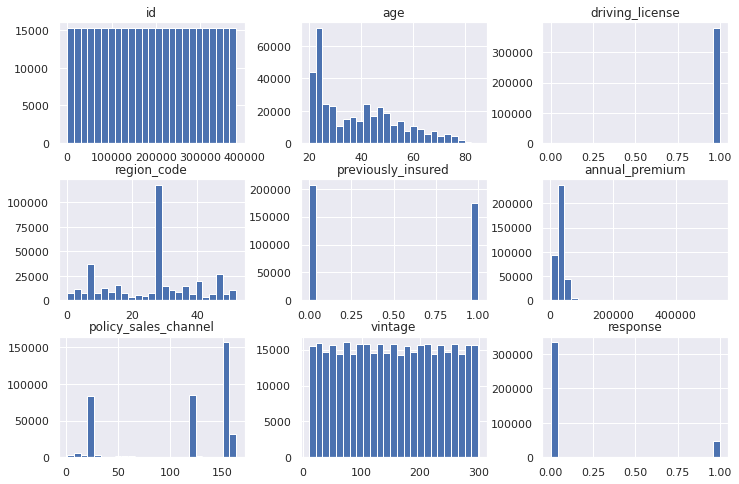

In [20]:
num_attr.hist(bins=25)

### 4.1.2 Categorical Attributes

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

<AxesSubplot:xlabel='response', ylabel='Density'>

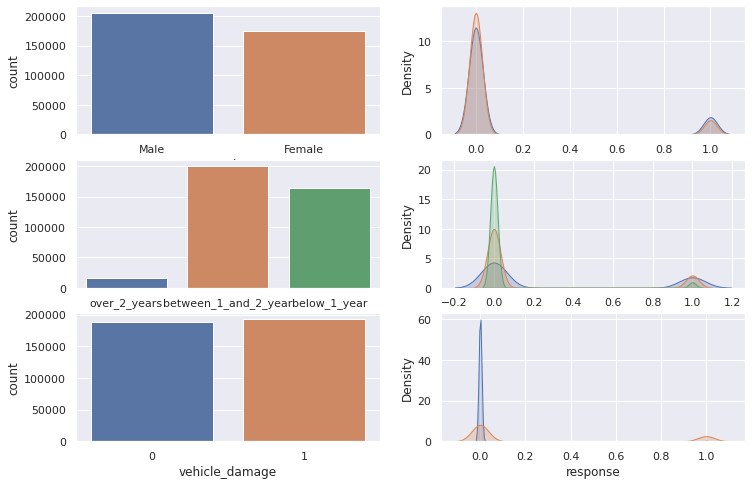

In [21]:
plt.subplot(3, 2, 1)
sns.countplot(df4['gender'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label='gender', shade=True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label='gender', shade=True)

plt.subplot(3, 2, 3)
sns.countplot(df4['vehicle_age'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['vehicle_age'] == 'over_2_years']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'between_1_and_2_year']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'below_1_year']['response'], label='vehicle_age', shade=True)

plt.subplot(3, 2, 5)
sns.countplot(df4['vehicle_damage'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['vehicle_damage'] == 0]['response'], label='vehicle_damage', shade=True)
sns.kdeplot(df4[df4['vehicle_damage'] == 1]['response'], label='vehicle_damage', shade=True)

## 4.2 Bivariete Analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

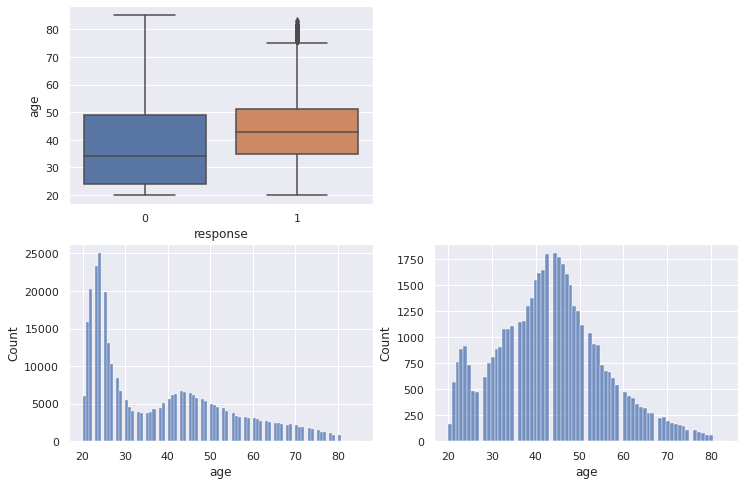

In [22]:
# age    
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux0)

In [23]:
# driving_license
aux = df4[['response', 'driving_license']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
#sns.barplot(x='response', y='driving_license_perc', data=aux)

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

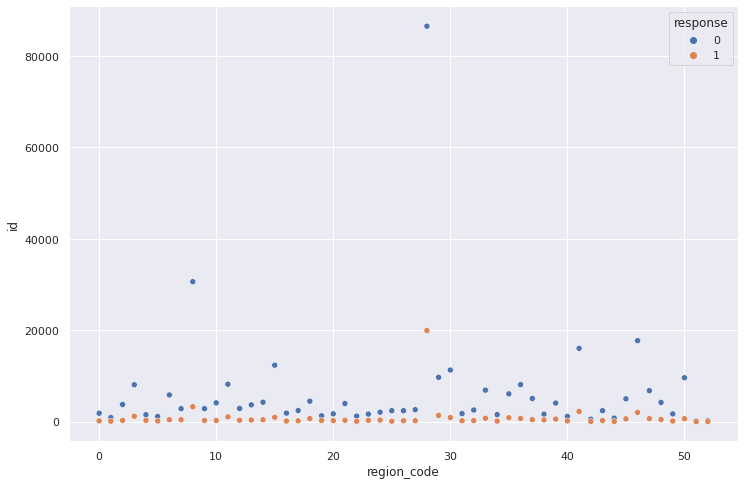

In [24]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [25]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [26]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_and_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_and_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [27]:
# vehicle_damage
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

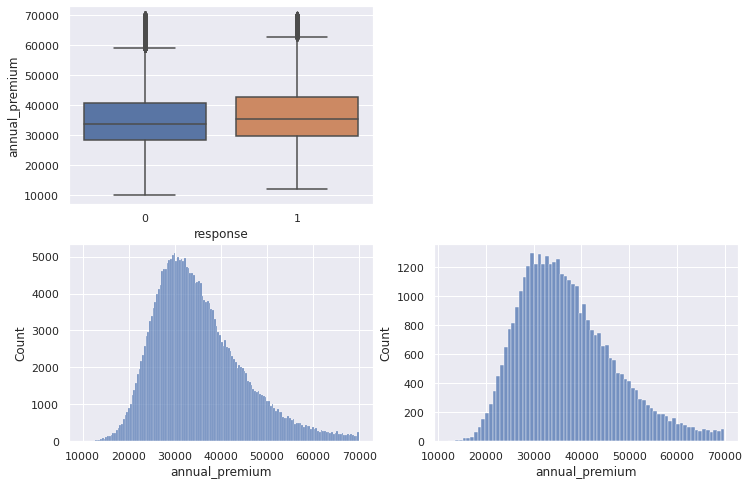

In [28]:
# annual_premium
plt.subplot(2, 2, 1)
aux = df4[(df4['annual_premium']<70000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response', y='annual_premium', data=aux)

plt.subplot(2, 2, 3)
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux0)

In [29]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
#aux.set_index('policy_sales_channel').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
aux.sample(10)

,policy_sales_channel,response
46,48.0,1
89,94.0,9
29,31.0,160
138,145.0,23
125,130.0,2
71,74.0,0
49,51.0,1
102,107.0,2
37,39.0,1
21,23.0,58


<AxesSubplot:xlabel='vintage', ylabel='Count'>

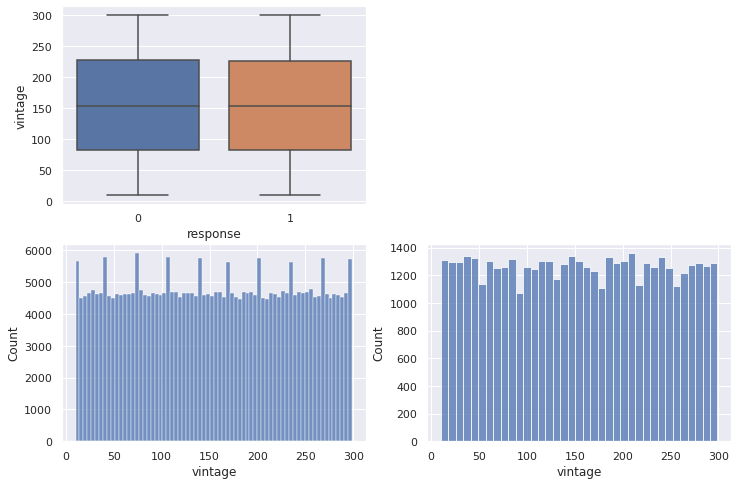

In [30]:
# vintage
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux0)

## 4.3 Multivariate Analysis

### 4.2.1 Numerical attributes

<AxesSubplot:>

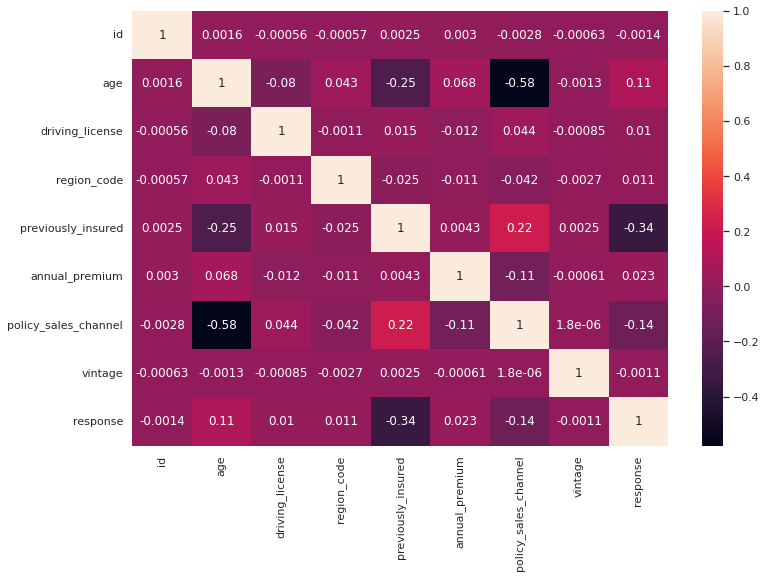

In [31]:
correlation = num_attr.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.2.2 Categorical attributes

In [32]:
cat_attr.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [33]:
# only categorical data
a = cat_attr

# Calculate cramver_v
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3],
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9]
                  } )

d = d.set_index(d.columns)

<AxesSubplot:>

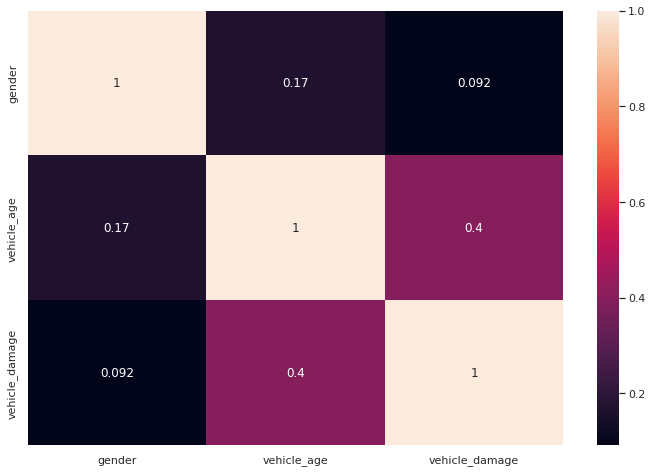

In [34]:
sns.heatmap(d, annot=True)

# 5.0 Data preparation

In [35]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)
x_val_api = x_val.copy()
df5 = pd.concat([x_train, y_train], axis=1)

In [36]:
x_val.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage'],
      dtype='object')

## 5.1 Standardization

In [37]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/age_scaler.pkl', 'wb'))
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/vintage_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [39]:
# driving_license -- Label encoding -- Já esta no formato
# vehicle_damage -- Label encoding -- Já esta no formato
# previously_insured -- Label encoding -- Já esta no formato

# gender -- Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/gender_scaler.pkl', 'wb'))

# region_code -- Target encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/region_code_scaler.pkl', 'wb'))

# vehicle_age -- One Hot Encoding / Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel -- Frequency encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/policy_sales_channel_scaler.pkl', 'wb'))

## 5.4 Validation Preparation

In [40]:
# annual_premium
x_val.loc[:,'annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# age
x_val.loc[:, 'age'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val.loc[:,'vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# gender
x_val.loc[:, 'gender'] = x_val.loc[:,'gender'].map(target_encode_gender)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:,'region_code'].map(target_encode_region_code)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:,'policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)

# 6.0 Feature selection

## 6.2 Features Importance

In [41]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs=-1)

#data preparation
x_train_n = df5.drop(['id','response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                            feature  importance
0                           vintage    0.273473
0                    annual_premium    0.245088
0                               age    0.166354
0                       region_code    0.103616
0                    vehicle_damage    0.067500
0              policy_sales_channel    0.058995
0                previously_insured    0.056526
0          vehicle_age_below_1_year    0.014331
0  vehicle_age_between_1_and_2_year    0.006511
0                            gender    0.004869
0          vehicle_age_over_2_years    0.002259
0                   driving_license    0.000479


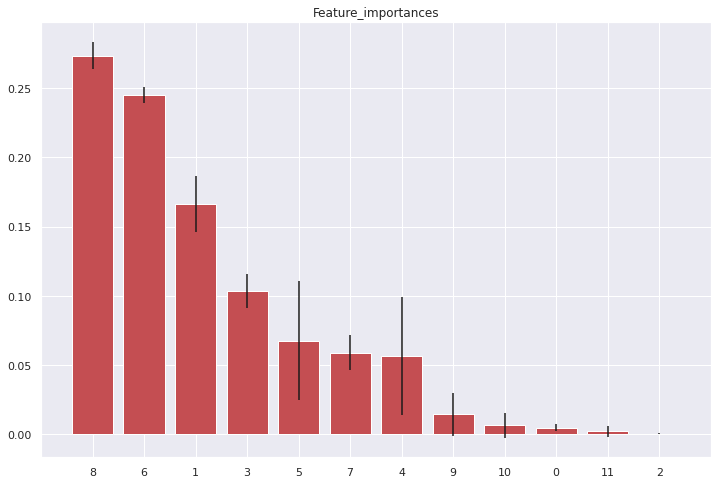

In [42]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature Ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux=pd.DataFrame({'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature_importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim((-1, x_train_n.shape[1]))
plt.show()

# 7.0 Machine learning modeling

In [43]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_selected]
x_validation = x_val[cols_selected]

## 7.1 KNN

In [44]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit( x_train, y_train)

# model prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba(x_validation)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

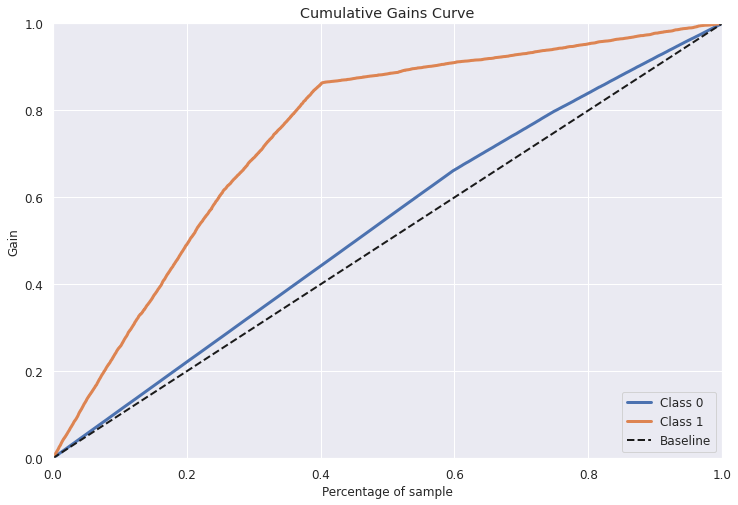

In [45]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

## 7.2 Logistic Regression

In [46]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_validation)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

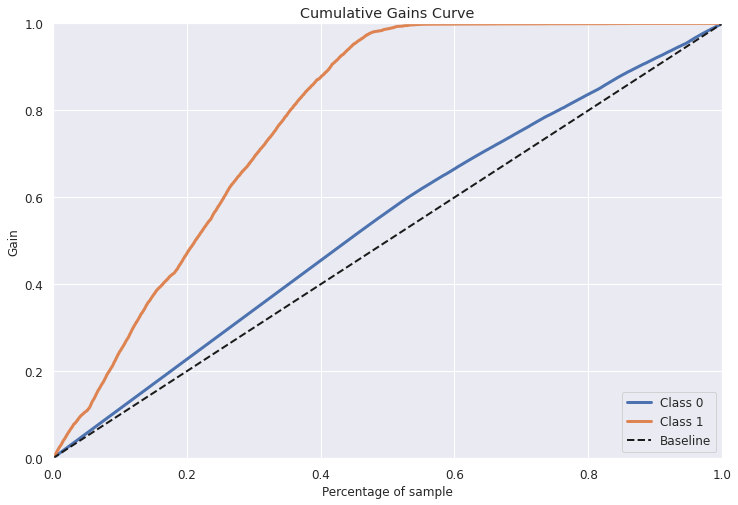

In [47]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

## 7.3 Extra Trees

In [48]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1,random_state=42)

# model training
et_model.fit(x_train, y_train)

# model prediction
yhat_et = et_model.predict_proba(x_validation)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

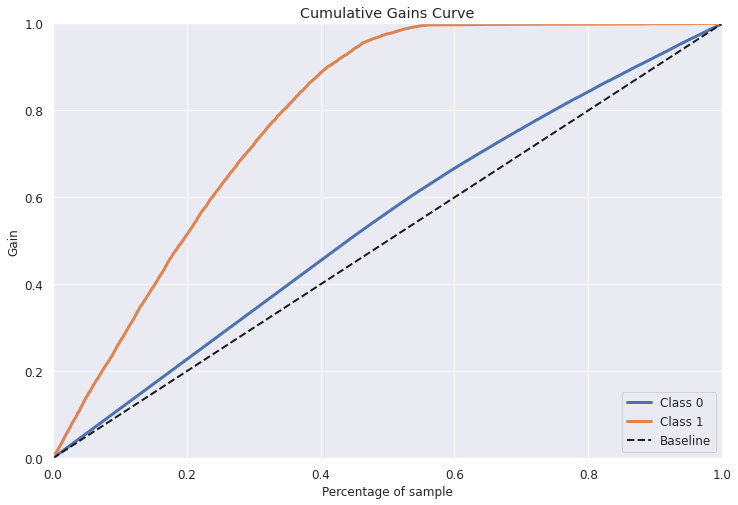

In [49]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et)

# 8.0 Model Performance

In [50]:
df8 = x_val.copy()
df8['response'] = y_val.copy()

## 8.1 KNN

In [51]:
df8_knn = df8.copy()
# propensity score
df8_knn['score'] = yhat_knn[:,1].tolist()

# sorted clients by score
df8_knn = df8_knn.sort_values('score', ascending=False)

# compute precision at k
#precision_at_50 = precision_at_k(df8_knn, k=20)
#print("precision_at_50:{}".format(precision_at_50))

# compute recall at k
#recall_at_50 = recall_at_k(df8_knn, k=20)
#print("recall_at_50:{}".format(recall_at_50))

knn_result = ml_metrics('KNN', df8_knn, k=20)
knn_result

,Model Name,Recall_at_K,Precision_at_K
0,KNN,0.000978,0.428571


## 8.2 Logistic Regression

In [52]:
df8_lr = df8.copy()
# propensity score
df8_lr['score'] = yhat_lr[:,1].tolist()

# sorted clients by score
df8_lr = df8_lr.sort_values('score', ascending=False)

# # compute precision at k
# precision_at_50 = precision_at_k(df8_lr, k=20)
# print("precision_at_50:{}".format(precision_at_50))

# # compute recall at k
# recall_at_50 = recall_at_k(df8_lr, k=20)
# print("recall_at_50:{}".format(recall_at_50))

lr_result = ml_metrics('Logistic Regression', df8_lr, k=20)
lr_result

,Model Name,Recall_at_K,Precision_at_K
0,Logistic Regression,0.000435,0.190476


## 8.3 Extra Trees

In [53]:
df8_et = df8.copy()
# propensity score
df8_et['score'] = yhat_et[:,1].tolist()

# sorted clients by score
df8_et = df8_et.sort_values('score', ascending=False)

# # compute precision at k
# precision_at_50 = precision_at_k(df8_et, k=20)
# print("precision_at_50:{}".format(precision_at_50))

# # compute recall at k
# recall_at_50 = recall_at_k(df8_et, k=20)
# print("recall_at_50:{}".format(recall_at_50))

et_result = ml_metrics('Extra Trees', df8_et, k=20)
et_result

,Model Name,Recall_at_K,Precision_at_K
0,Extra Trees,0.000543,0.238095


## 8.4 Cumulative Gain Logistic Regression

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

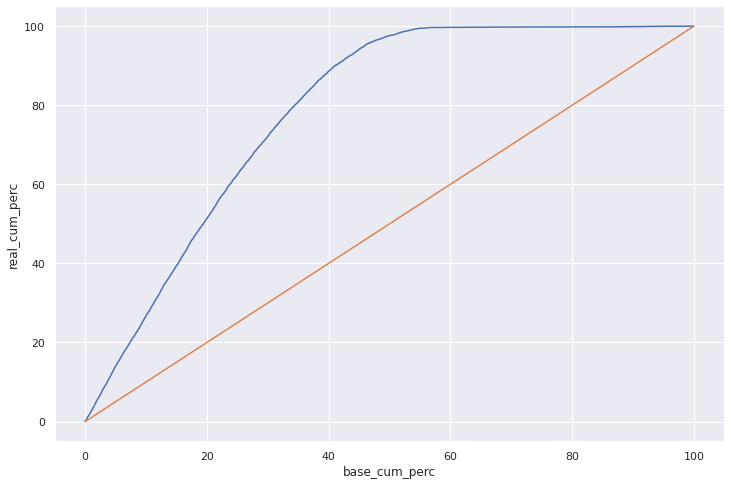

In [54]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## 8.5 Lift Curve Logistic Regression

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

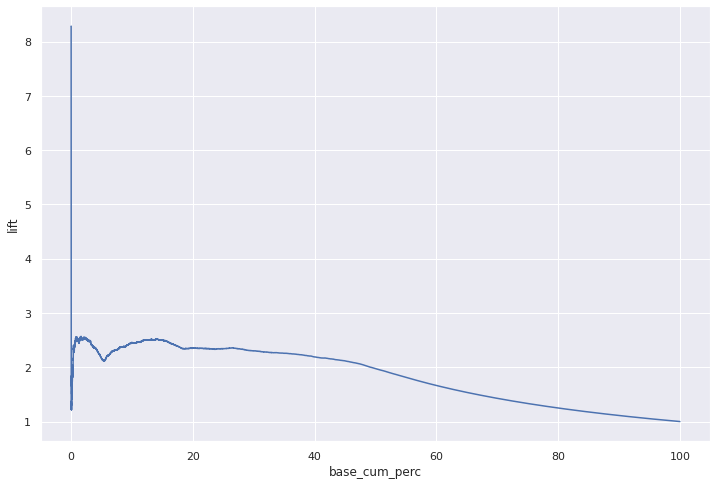

In [55]:
results = pd.DataFrame()
results['prediction'] = yhat_lr[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

# 9.0 Deploy to production

In [56]:
pickle.dump(lr_model, open('/home/romulo/Documentos/health_insurance/health_insurance/src/models/model_linear_regression.pkl','wb'))

## 9.3 API Tester

In [57]:
import json

In [58]:
import requests

In [59]:
 # loading test dataset
#x_val_api = x_val_api.drop(['response'], axis=1)
df_test = x_val_api

In [60]:
 df_test = df_test.sample(10)

In [61]:
 # convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [62]:
 data

'[{"id": 268807, "gender": "Female", "age": 52, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "over_2_years", "vehicle_damage": 1, "annual_premium": 60012.0, "policy_sales_channel": 26.0, "vintage": 14}, {"id": 227484, "gender": "Female", "age": 58, "driving_license": 1, "region_code": 41.0, "previously_insured": 0, "vehicle_age": "between_1_and_2_year", "vehicle_damage": 1, "annual_premium": 22768.0, "policy_sales_channel": 26.0, "vintage": 180}, {"id": 373733, "gender": "Female", "age": 39, "driving_license": 1, "region_code": 41.0, "previously_insured": 1, "vehicle_age": "between_1_and_2_year", "vehicle_damage": 0, "annual_premium": 23801.0, "policy_sales_channel": 122.0, "vintage": 139}, {"id": 98612, "gender": "Male", "age": 62, "driving_license": 1, "region_code": 48.0, "previously_insured": 0, "vehicle_age": "over_2_years", "vehicle_damage": 1, "annual_premium": 2630.0, "policy_sales_channel": 157.0, "vintage": 291}, {"id": 288404, "gender": 

In [63]:
# save json in file
with open('data.json', 'w') as o:
    o.write(data)

# save json file in csv
data_json = pd.read_json('data.json')
data_json.to_csv('data.csv')

In [64]:
 # API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model-rf.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [65]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,prediction
9,7185,0.139808,0.276923,1,0.188381,0,below_1_year,0,-0.104382,150.0,0.629758,0.056969
6,243902,0.104237,0.292308,1,0.188381,0,below_1_year,0,0.454667,26.0,0.795848,0.048894
5,28282,0.139808,0.184615,1,0.153074,0,below_1_year,0,0.228769,156.0,0.003460,0.048016
0,268807,0.104237,0.492308,1,0.188381,0,below_1_year,0,1.712860,26.0,0.013841,0.047329
3,98612,0.139808,0.646154,1,0.104636,0,below_1_year,0,-1.622828,157.0,0.972318,0.036521
1,227484,0.104237,0.584615,1,0.123899,0,below_1_year,0,-0.452181,26.0,0.588235,0.034756
7,3241,0.139808,0.107692,1,0.081586,0,below_1_year,0,0.210632,152.0,0.477509,0.027681
8,8107,0.139808,0.030769,1,0.066477,0,below_1_year,0,-1.622828,152.0,0.608997,0.025822
2,373733,0.104237,0.292308,1,0.123899,1,below_1_year,0,-0.392131,122.0,0.446367,0.000835
4,288404,0.104237,0.015385,1,0.078817,1,below_1_year,0,0.732650,152.0,0.975779,0.000554
